### RANDOM FOREST MODEL

In [3]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

In [49]:
def load_data(years = ['2013','2014','2015']):
    file_name_1 = 'elspot-prices_'
    file_name_2 = '_hourly_dkk.csv'
    data_folder = os.getcwd().replace('notebook','data\\')
    all_data=[]
    for year in years:
        file_name_tot = data_folder + file_name_1 + year + file_name_2
        all_data.append(pd.read_csv(file_name_tot,encoding = "ISO-8859-1",sep=';',decimal=','))
    df = pd.concat(all_data, ignore_index=True,sort= True)
    return df
    

In [84]:
def generate_shifted_features(df,time_shift,colname):
    pd.options.mode.chained_assignment = None
    df = df.drop([ 'DK1', 'DK2', 'EE', 'ELE', 'FI', 'FRE', 'Kr.sand', 'LT', 'LV',
       'Molde', 'Oslo', 'SE1', 'SE2', 'SE3', 'SE4', 'SYS', 'Tr.heim', 'Tromsø'],errors='ignore',axis=1)

    for t in time_shift:
        df.loc[:,colname+'_'+str(t)] = df.Bergen.shift(t)
    return df

In [70]:
def generate_shifted_labels(df,time_shift,colname):
    pd.options.mode.chained_assignment = None
    df = df.drop([ 'DK1', 'DK2', 'EE', 'ELE', 'FI', 'FRE', 'Kr.sand', 'LT', 'LV',
       'Molde', 'Oslo', 'SE1', 'SE2', 'SE3', 'SE4', 'SYS', 'Tr.heim', 'Tromsø'],axis=1,errors='ignore')
    labels = list([colname])
    for t in time_shift:
        df.loc[:,colname+'_plus_'+str(t)] = df[colname].shift(-t)
        labels.append(colname+'_plus_'+str(t))
        
    return df, labels

In [89]:
def generate_calendar_features(df):
    
    df['Month'] = df['datetime'].apply(lambda x: np.int(x[3:5]))
    df['Hour'] = df['Hours'].apply(lambda x: np.int(x[0:2]))
    df = pd.concat([df,pd.get_dummies(df['Month'],prefix='month'),pd.get_dummies(df['Hour'],prefix='hour')],axis=1)
    df = df.drop(['Month','month_12','Hours','Hour','hour_0'],axis=1)
    
    return df

In [95]:
def create_train_test(df,labels,test_size = 8000):
    df = df.dropna()
    train_size = df.shape[0]-test_size
    
    X_train = df.drop(['Bergen','datetime'],axis=1,errors='ignore').head(train_size)
    X_train = X_train.drop(labels,axis=1,errors='ignore')
    y_train = df[labels].head(train_size)
    X_test = df.drop(['Bergen','datetime'],axis=1,errors='ignore').tail(test_size)
    X_test = X_test.drop(labels,axis=1,errors='ignore')
    y_test = df[labels].tail(test_size)
    
    return X_train, y_train, X_test, y_test
    

In [54]:
def gridsearch_rf(rf, X_train , y_train , param_grid , n_jobs = -1):
    cv = KFold(4)
    scorer = make_scorer(mean_absolute_error)
    rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, cv = cv, scoring = scorer, verbose=2, n_jobs = n_jobs)
    rf_grid.fit(X_train, y_train)
    model = rf_grid.best_estimator_
    return model

In [120]:
def predict_model(model ,X_test ,y_test ):
    y_pred = model.predict(X_test)
    
    if y_test.shape[1]==1:
        mae = mean_absolute_error(y_test,y_pred)
        rmse = sqrt(mean_squared_error(y_test,y_pred))
        print('MAE = {:.2f}, RMSE = {:.2f}'.format(mae,rmse))
    else:
        mae=list()
        rmse=list()
        for i in range(y_test.shape[1]):
            mae.append(mean_absolute_error(y_test.iloc[:,i],y_pred[:,i]))
            rmse.append(sqrt(mean_squared_error(y_test.iloc[:,i],y_pred[:,i])))
            
    return y_pred,mae,rmse
    

In [56]:
def plot_predictions(y_test , y_pred ,plot_samples=100,size=(15,5)):
    plt.figure(figsize=size)
    plt.title('Example of model predictions')
    plt.scatter(range(plot_samples),y_test[:plot_samples],color='b')
    plt.scatter(range(plot_samples),y_pred[:plot_samples],color='r')
    plt.show()
    return

In [57]:
df = load_data()
time_shift = [1,3,6,9,12,24,36,48,60]
df_bergen = generate_shifted_features(df,time_shift,'Bergen')
df_bergen = generate_calendar_features(df_bergen)
X_train, y_train, X_test, y_test = create_train_test(df_bergen,test_size = 8000)

TypeError: create_train_test() missing 1 required positional argument: 'labels'

In [123]:
# Number of trees in random forest
n_estimators = [5,10,30]
# Number of features to consider at every split
max_features = ['sqrt',None]
# Maximum number of levels in tree
max_depth = [6,9,12]
# Minimum number of samples required to split a node
min_samples_split = [2,4, 8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [27]:
# Number of trees in random forest
base_estimator = [DecisionTreeRegressor(max_depth=15)]
base_estimator = [RandomForestRegressor()]
n_estimators = [5,10,20,30]
# Number of features to consider at every split
learning_rate = [0.1,0.5,0.75,1]
# Maximum number of levels in tree
loss = ['linear','square','exponential']
# Create the random grid
param_grid = {'base_estimator': base_estimator,
              'n_estimators': n_estimators,
              'learning_rate': learning_rate,
              'loss': loss}

In [14]:
model = gridsearch_rf(AdaBoostRegressor(),n_jobs = 6)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 13.1min
[Parallel(n_jobs=6)]: Done 192 out of 192 | elapsed: 16.6min finished


In [15]:
print(model)

AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
         learning_rate=0.75, loss='square', n_estimators=5,
         random_state=None)


In [17]:
y_pred, mae, rmse = predict_model()

MAE = 5.35, RMSE = 11.52


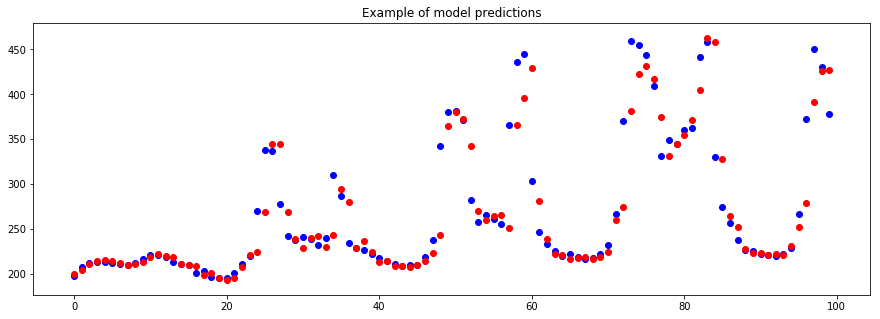

In [19]:
plot_predictions()

### FEATURE IMPORTANCE AND FEATURE SELECTION

In [34]:
def plot_importance(size=(10,10)):
    features = X_train.columns.values
    importances = model.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=size)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [40]:
def select_top_features(X_train, X_test,top_k = 10):
    features = X_train.columns.values
    importances = model.feature_importances_
    indices = np.argsort(importances)
    indices_top_k = indices[::-1][:top_k]
    features_top_k = features[indices_top_k]
    X_train = X_train[features_top_k]
    X_test = X_test[features_top_k]
    return X_train, X_test

In [41]:
X_train, X_test = select_top_features(X_train, X_test,top_k = 10)

In [44]:
model = gridsearch_rf(AdaBoostRegressor(),n_jobs = 8)

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 192 out of 192 | elapsed:  6.6min finished


In [45]:
y_pred, mae, rmse = predict_model()

MAE = 5.35, RMSE = 11.52


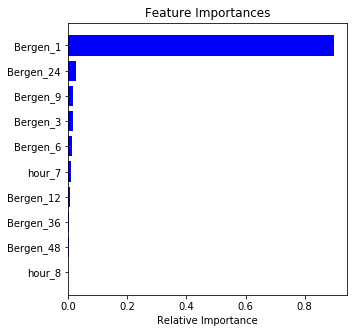

In [49]:
plot_importance()

### MULTI OUTPUT MODEL: 24H FORECAST

In [112]:
df = load_data()
time_shift_features = [1,2,3,4,5,6,7,8,9,10,11,12,24,36,48,60]
df = generate_shifted_features(df,time_shift_features,'Bergen')
time_shift_labels = range(1,24)
df, labels = generate_shifted_labels(df,time_shift_labels,'Bergen')
df = generate_calendar_features(df)
df.head()

,Bergen,datetime,Bergen_1,Bergen_2,Bergen_3,Bergen_4,Bergen_5,Bergen_6,Bergen_7,Bergen_8,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,246.01,01/01/2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,245.94,01/01/2013,246.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,243.11,01/01/2013,245.94,246.01,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,235.20,01/01/2013,243.11,245.94,246.01,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,227.81,01/01/2013,235.20,243.11,245.94,246.01,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [113]:
df.columns

Index(['Bergen', 'datetime', 'Bergen_1', 'Bergen_2', 'Bergen_3', 'Bergen_4',
       'Bergen_5', 'Bergen_6', 'Bergen_7', 'Bergen_8', 'Bergen_9', 'Bergen_10',
       'Bergen_11', 'Bergen_12', 'Bergen_24', 'Bergen_36', 'Bergen_48',
       'Bergen_60', 'Bergen_plus_1', 'Bergen_plus_2', 'Bergen_plus_3',
       'Bergen_plus_4', 'Bergen_plus_5', 'Bergen_plus_6', 'Bergen_plus_7',
       'Bergen_plus_8', 'Bergen_plus_9', 'Bergen_plus_10', 'Bergen_plus_11',
       'Bergen_plus_12', 'Bergen_plus_13', 'Bergen_plus_14', 'Bergen_plus_15',
       'Bergen_plus_16', 'Bergen_plus_17', 'Bergen_plus_18', 'Bergen_plus_19',
       'Bergen_plus_20', 'Bergen_plus_21', 'Bergen_plus_22', 'Bergen_plus_23',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15

In [114]:
X_train, y_train, X_test, y_test = create_train_test(df,labels,test_size = 8000)

In [124]:
model = gridsearch_rf(RandomForestRegressor(),X_train, y_train,param_grid,n_jobs = 8)

Fitting 4 folds for each of 324 candidates, totalling 1296 fits


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   25.2s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:  4.4min
[Parallel(n_jobs=8)]: Done 1296 out of 1296 | elapsed:  7.2min finished


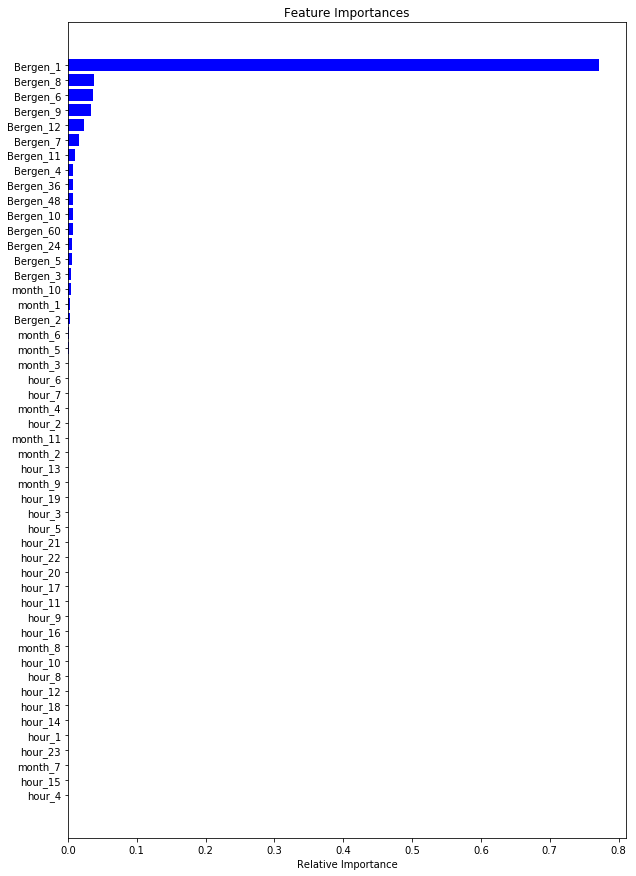

In [125]:
plot_importance(size=(10,15))

In [126]:
y_pred, mae, rmse = predict_model(model, X_test,y_test)

In [127]:
print(mae)
print(rmse)

[14.713253582699021, 18.596738380243703, 21.529912723712386, 23.882251488616713, 25.233101048852163, 26.058012087681487, 26.40619183712375, 26.05452179757391, 26.872258893410034, 26.184803507269063, 25.89249275875291, 26.16703678367206, 26.68024895087464, 27.147012426159584, 27.050620775209847, 27.35283393532928, 27.58759820395185, 27.27781908730882, 27.377360852938484, 27.1800730704512, 26.55593793232942, 26.262096411055747, 26.53022657374939, 26.834274776597848]
[25.459532440396885, 30.729234425174894, 34.6823948795625, 37.33696943945945, 38.75239623449966, 39.82008793031789, 40.64099331440179, 40.12017048136023, 40.69759439551625, 39.11445015295801, 38.174392333794536, 38.17648449861413, 38.85115913058738, 39.81447039338227, 40.19174583834425, 41.490098345415035, 41.146283726862144, 40.09287568894192, 40.083073427765534, 40.09356378979745, 39.52702747652749, 38.990319822925166, 39.13328736871097, 39.76683872923514]
